## Functions

In [1]:
# %matplotlib inline

import numpy as np
from skimage import transform, io, filters
import skimage.util
import os
import glob
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, BatchNormalization
from keras import layers
import tensorflow as tf
import time
from keras import backend as K
# from tensorflow.keras import layers

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


def get_unet_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

def path_planning_model():
    x = Input(shape=(None, None, 1))

    net = Conv2D(filters=64, kernel_size=[3, 3], strides=[1, 1], padding="same", kernel_initializer='orthogonal', activation='relu')(x)
    net = BatchNormalization()(net)
    for i in range(19):
        net = Conv2D(filters=64, kernel_size=[3, 3], strides=[1, 1], padding="same", kernel_initializer='orthogonal', activation='relu')(net)
        net = BatchNormalization()(net)
        
    net = Conv2D(filters=1, kernel_size=[3, 3], strides=[1, 1], padding="same", kernel_initializer='orthogonal', activation='sigmoid')(net)
    net = BatchNormalization()(net)
    # net = Conv2D(filters=1, kernel_size=[3, 3], strides=[1, 1], padding="same", kernel_initializer='orthogonal', activation='sigmoid')(net)
    # net = BatchNormalization()(net)	
    net = Dropout(0.10)(net)
    # Define the model
    model = keras.Model(inputs=x, outputs=net)
    return model

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred.flatten(), 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    b = plt.plot(t['pred'].tolist(),label='prediction',color = 'orange')
    a = plt.plot(t['y'].tolist(),label='expected',color = 'blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()

Using TensorFlow backend.
/home/chris/anaconda3/envs/AI4AVenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/chris/anaconda3/envs/AI4AVenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/chris/anaconda3/envs/AI4AVenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/chris/anaco

## Data

In [2]:
# Base data directories
root_dir = ".."
data_dir = os.path.join(root_dir,"data")

bugtrap_forest_dir = os.path.join(data_dir, "bugtrap_forest" )
forest_dir = os.path.join(data_dir, "forest" )
multiple_bugraps_dir = os.path.join(data_dir, "multiple_bugtraps" )
shifting_gaps_dir = os.path.join(data_dir, "shifting_gaps" )

## Mazes

In [3]:
# Mazes
mazes_dir = os.path.join(data_dir, "mazes" )
mazes_train_csv_path = os.path.join(mazes_dir,"mazes_train.csv")
mazes_test_csv_path = os.path.join(mazes_dir,"mazes_test.csv")
mazes_valid_csv_path = os.path.join(mazes_dir,"mazes_validation.csv")
mazes_train_data = pd.read_csv(mazes_train_csv_path)
mazes_test_data = pd.read_csv(mazes_test_csv_path)
mazes_valid_data = pd.read_csv(mazes_valid_csv_path)

### Train Data

In [4]:
# X - Map image file
# Y - Path image file

x_train_imgs = glob.glob(os.path.join(mazes_dir, "train/*.png"))
x_imgs_train = []
x_labels_train_mazes = []
for img_path in x_train_imgs:
    img = io.imread(img_path, as_gray=True)
    x_imgs_train.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_train_mazes.append(img_name)
print("X_train_mazes")
print(f"# of images: {len(x_imgs_train)}")
X_train_mazes = np.array(x_imgs_train, dtype='float32')
X_train_mazes/=255
print(f"{X_train_mazes.ndim}")
print(f"{X_train_mazes.shape}")
# print(f"{X_train_mazes.dtype.names}")
# print(f"{X_train_mazes[0]}")

y_train_imgs = glob.glob(os.path.join(mazes_dir, "train_path/*.png"))
y_imgs_train = []
y_labels_train_mazes = []
for img_path in y_train_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_train.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_train_mazes.append(img_name)
print("y_train_mazes")
print(f"# of images: {len(y_imgs_train)}")
y_train_mazes = np.array(y_imgs_train, dtype='float32')
y_train_mazes/=255
print(f"{y_train_mazes.ndim}")
print(f"{y_train_mazes.shape}")
# print(f"{y_train_mazes.dtype.names}")
# print(f"{y_train_mazes[0]}")

X_train_mazes
# of images: 800
3
(800, 32, 32)
y_train_mazes
# of images: 800
3
(800, 32, 32)


### Validation Data

In [5]:
x_valid_imgs = glob.glob(os.path.join(mazes_dir, "validation/*.png"))
x_imgs_valid = []
x_labels_valid_mazes = []
for img_path in x_valid_imgs:
    img = io.imread(img_path, as_gray=True)
    x_imgs_valid.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_valid_mazes.append(img_name)
print("X_valid_mazes")
print(f"# of images: {len(x_imgs_valid)}")
X_valid_mazes = np.array(x_imgs_valid, dtype='float32')
X_valid_mazes/=255
print(f"{X_valid_mazes.ndim}")
print(f"{X_valid_mazes.shape}")
# print(f"{X_valid_mazes.dtype.names}")
# print(f"{X_valid_mazes[0]}")

y_valid_imgs = glob.glob(os.path.join(mazes_dir, "validation_path/*.png"))
y_imgs_valid = []
y_labels_valid_mazes = []
for img_path in y_valid_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_valid.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_valid_mazes.append(img_name)
print("y_valid_mazes")
print(f"# of images: {len(y_imgs_valid)}")
y_valid_mazes = np.array(y_imgs_valid, dtype='float32')
y_valid_mazes/=255
print(f"{y_valid_mazes.ndim}")
print(f"{y_valid_mazes.shape}")
# print(f"{y_valid_mazes.dtype.names}")
# print(f"{y_valid_mazes[0]}")

X_valid_mazes
# of images: 100
3
(100, 32, 32)
y_valid_mazes
# of images: 100
3
(100, 32, 32)


### Test Data

In [6]:
x_test_imgs = glob.glob(os.path.join(mazes_dir, "test/*.png"))
imgs_test = []
x_labels_test_mazes = []
for img_path in x_test_imgs:
    img = io.imread(img_path, as_gray=True)
    imgs_test.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_test_mazes.append(img_name)
print("X_test_mazes")
print(f"# of images: {len(imgs_test)}")
X_test_mazes = np.array(imgs_test, dtype='float32')
X_test_mazes/=255
# X_test = np.array(imgs_test)
print(f"{X_test_mazes.ndim}")
print(f"{X_test_mazes.shape}")
# print(f"{X_test_mazes.dtype.names}")
# print(f"{X_test_mazes[0]}")

y_test_imgs = glob.glob(os.path.join(mazes_dir, "test_path/*.png"))
y_imgs_test = []
y_labels_test_mazes = []
for img_path in y_test_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_test.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_test_mazes.append(img_name)
print("y_test_mazes")
print(f"# of images: {len(y_imgs_test)}")
y_test_mazes = np.array(y_imgs_test, dtype='float32')
y_test_mazes/=255
print(f"{y_test_mazes.ndim}")
print(f"{y_test_mazes.shape}")
# print(f"{y_test_mazes.dtype.names}")
# print(f"{y_test_mazes[0]}")

X_test_mazes
# of images: 100
3
(100, 32, 32)
y_test_mazes
# of images: 100
3
(100, 32, 32)


In [7]:
# input_shape = (32, 32, 1)
img_rows, img_cols = 32, 32
if K.image_data_format() == 'channels_first':
    X_train_mazes = X_train_mazes.reshape(X_train_mazes.shape[0], 1, img_rows, img_cols)
    X_valid_mazes = X_valid_mazes.reshape(X_valid_mazes.shape[0], 1, img_rows, img_cols)
    X_test_mazes = X_test_mazes.reshape(X_test_mazes.shape[0], 1, img_rows, img_cols)
    y_train_mazes = y_train_mazes.reshape(y_train_mazes.shape[0], 1, img_rows, img_cols)
    y_valid_mazes = y_valid_mazes.reshape(y_valid_mazes.shape[0], 1, img_rows, img_cols)
    y_test_mazes = y_test_mazes.reshape(y_test_mazes.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train_mazes = X_train_mazes.reshape(X_train_mazes.shape[0], img_rows, img_cols, 1)
    X_valid_mazes = X_valid_mazes.reshape(X_valid_mazes.shape[0], img_rows, img_cols, 1)
    X_test_mazes = X_test_mazes.reshape(X_test_mazes.shape[0], img_rows, img_cols, 1)
    y_train_mazes = y_train_mazes.reshape(y_train_mazes.shape[0], img_rows, img_cols, 1)
    y_valid_mazes = y_valid_mazes.reshape(y_valid_mazes.shape[0], img_rows, img_cols, 1)
    y_test_mazes = y_test_mazes.reshape(y_test_mazes.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

## Alternating Gaps

In [8]:
# alternating_gaps
alternating_gaps_dir = os.path.join(data_dir, "alternating_gaps" )
alternating_gaps_train_csv_path = os.path.join(alternating_gaps_dir,"alternating_gaps_train.csv")
alternating_gaps_test_csv_path = os.path.join(alternating_gaps_dir,"alternating_gaps_test.csv")
alternating_gaps_valid_csv_path = os.path.join(alternating_gaps_dir,"alternating_gaps_validation.csv")
alternating_gaps_train_data = pd.read_csv(alternating_gaps_train_csv_path)
alternating_gaps_test_data = pd.read_csv(alternating_gaps_test_csv_path)
alternating_gaps_valid_data = pd.read_csv(alternating_gaps_valid_csv_path)

### Train Data

In [9]:
# X - Map image file
# Y - Path image file

x_train_imgs = glob.glob(os.path.join(alternating_gaps_dir, "train/*.png"))
x_imgs_train = []
x_labels_train_alternating_gaps = []
for img_path in x_train_imgs:
    img = io.imread(img_path, as_gray=True)
    x_imgs_train.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_train_alternating_gaps.append(img_name)
print("X_train_alternating_gaps")
print(f"# of images: {len(x_imgs_train)}")
X_train_alternating_gaps = np.array(x_imgs_train, dtype='float32')
X_train_alternating_gaps/=255
print(f"{X_train_alternating_gaps.ndim}")
print(f"{X_train_alternating_gaps.shape}")
# print(f"{X_train_alternating_gaps.dtype.names}")
# print(f"{X_train_alternating_gaps[0]}")

y_train_imgs = glob.glob(os.path.join(alternating_gaps_dir, "train_path/*.png"))
y_imgs_train = []
y_labels_train_alternating_gaps = []
for img_path in y_train_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_train.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_train_alternating_gaps.append(img_name)
print("y_train_alternating_gaps")
print(f"# of images: {len(y_imgs_train)}")
y_train_alternating_gaps = np.array(y_imgs_train, dtype='float32')
y_train_alternating_gaps/=255
print(f"{y_train_alternating_gaps.ndim}")
print(f"{y_train_alternating_gaps.shape}")
# print(f"{y_train_alternating_gaps.dtype.names}")
# print(f"{y_train_alternating_gaps[0]}")

X_train_alternating_gaps
# of images: 800
3
(800, 32, 32)
y_train_alternating_gaps
# of images: 800
3
(800, 32, 32)


### Validation Data

In [10]:
x_valid_imgs = glob.glob(os.path.join(alternating_gaps_dir, "validation/*.png"))
x_imgs_valid = []
x_labels_valid_alternating_gaps = []
for img_path in x_valid_imgs:
    img = io.imread(img_path, as_gray=True)
    x_imgs_valid.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_valid_alternating_gaps.append(img_name)
print("X_valid_alternating_gaps")
print(f"# of images: {len(x_imgs_valid)}")
X_valid_alternating_gaps = np.array(x_imgs_valid, dtype='float32')
X_valid_alternating_gaps/=255
print(f"{X_valid_alternating_gaps.ndim}")
print(f"{X_valid_alternating_gaps.shape}")
# print(f"{X_valid_alternating_gaps.dtype.names}")
# print(f"{X_valid_alternating_gaps[0]}")

y_valid_imgs = glob.glob(os.path.join(alternating_gaps_dir, "validation_path/*.png"))
y_imgs_valid = []
y_labels_valid_alternating_gaps = []
for img_path in y_valid_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_valid.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_valid_alternating_gaps.append(img_name)
print("y_valid_alternating_gaps")
print(f"# of images: {len(y_imgs_valid)}")
y_valid_alternating_gaps = np.array(y_imgs_valid, dtype='float32')
y_valid_alternating_gaps/=255
print(f"{y_valid_alternating_gaps.ndim}")
print(f"{y_valid_alternating_gaps.shape}")
# print(f"{y_valid_alternating_gaps.dtype.names}")
# print(f"{y_valid_alternating_gaps[0]}")

X_valid_alternating_gaps
# of images: 100
3
(100, 32, 32)
y_valid_alternating_gaps
# of images: 100
3
(100, 32, 32)


### Test Data

In [11]:
x_test_imgs = glob.glob(os.path.join(alternating_gaps_dir, "test/*.png"))
imgs_test = []
x_labels_test_alternating_gaps = []
for img_path in x_test_imgs:
    img = io.imread(img_path, as_gray=True)
    imgs_test.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_test_alternating_gaps.append(img_name)
print("X_test_alternating_gaps")
print(f"# of images: {len(imgs_test)}")
X_test_alternating_gaps = np.array(imgs_test, dtype='float32')
X_test_alternating_gaps/=255
# X_test = np.array(imgs_test)
print(f"{X_test_alternating_gaps.ndim}")
print(f"{X_test_alternating_gaps.shape}")
# print(f"{X_test_alternating_gaps.dtype.names}")
# print(f"{X_test_alternating_gaps[0]}")

y_test_imgs = glob.glob(os.path.join(alternating_gaps_dir, "test_path/*.png"))
y_imgs_test = []
y_labels_test_alternating_gaps = []
for img_path in y_test_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_test.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_test_alternating_gaps.append(img_name)
print("y_test_alternating_gaps")
print(f"# of images: {len(y_imgs_test)}")
y_test_alternating_gaps = np.array(y_imgs_test, dtype='float32')
y_test_alternating_gaps/=255
print(f"{y_test_alternating_gaps.ndim}")
print(f"{y_test_alternating_gaps.shape}")
# print(f"{y_test_alternating_gaps.dtype.names}")
# print(f"{y_test_alternating_gaps[0]}")

X_test_alternating_gaps
# of images: 100
3
(100, 32, 32)
y_test_alternating_gaps
# of images: 100
3
(100, 32, 32)


In [12]:
# input_shape = (32, 32, 1)
img_rows, img_cols = 32, 32
if K.image_data_format() == 'channels_first':
    X_train_alternating_gaps = X_train_alternating_gaps.reshape(X_train_alternating_gaps.shape[0], 1, img_rows, img_cols)
    X_valid_alternating_gaps = X_valid_alternating_gaps.reshape(X_valid_alternating_gaps.shape[0], 1, img_rows, img_cols)
    X_test_alternating_gaps = X_test_alternating_gaps.reshape(X_test_alternating_gaps.shape[0], 1, img_rows, img_cols)
    y_train_alternating_gaps = y_train_alternating_gaps.reshape(y_train_alternating_gaps.shape[0], 1, img_rows, img_cols)
    y_valid_alternating_gaps = y_valid_alternating_gaps.reshape(y_valid_alternating_gaps.shape[0], 1, img_rows, img_cols)
    y_test_alternating_gaps = y_test_alternating_gaps.reshape(y_test_alternating_gaps.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train_alternating_gaps = X_train_alternating_gaps.reshape(X_train_alternating_gaps.shape[0], img_rows, img_cols, 1)
    X_valid_alternating_gaps = X_valid_alternating_gaps.reshape(X_valid_alternating_gaps.shape[0], img_rows, img_cols, 1)
    X_test_alternating_gaps = X_test_alternating_gaps.reshape(X_test_alternating_gaps.shape[0], img_rows, img_cols, 1)
    y_train_alternating_gaps = y_train_alternating_gaps.reshape(y_train_alternating_gaps.shape[0], img_rows, img_cols, 1)
    y_valid_alternating_gaps = y_valid_alternating_gaps.reshape(y_valid_alternating_gaps.shape[0], img_rows, img_cols, 1)
    y_test_alternating_gaps = y_test_alternating_gaps.reshape(y_test_alternating_gaps.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

## Bugtrap Forest

In [13]:
# Bugtrap Forest
bugtrap_forest_dir = os.path.join(data_dir, "bugtrap_forest" )
bugtrap_forest_train_csv_path = os.path.join(bugtrap_forest_dir,"bugtrap_forest_train.csv")
bugtrap_forest_test_csv_path = os.path.join(bugtrap_forest_dir,"bugtrap_forest_test.csv")
bugtrap_forest_valid_csv_path = os.path.join(bugtrap_forest_dir,"bugtrap_forest_validation.csv")
bugtrap_forest_train_data = pd.read_csv(bugtrap_forest_train_csv_path)
bugtrap_forest_test_data = pd.read_csv(bugtrap_forest_test_csv_path)
bugtrap_forest_valid_data = pd.read_csv(bugtrap_forest_valid_csv_path)

### Train Data

In [14]:
# X - Map image file
# Y - Path image file

x_train_imgs = glob.glob(os.path.join(bugtrap_forest_dir, "train/*.png"))
x_imgs_train = []
x_labels_train_bugtrap_forest = []
for img_path in x_train_imgs:
    img = io.imread(img_path, as_gray=True)
    x_imgs_train.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_train_bugtrap_forest.append(img_name)
print("X_train_bugtrap_forest")
print(f"# of images: {len(x_imgs_train)}")
X_train_bugtrap_forest = np.array(x_imgs_train, dtype='float32')
X_train_bugtrap_forest/=255
print(f"{X_train_bugtrap_forest.ndim}")
print(f"{X_train_bugtrap_forest.shape}")
# print(f"{X_train_bugtrap_forest.dtype.names}")
# print(f"{X_train_bugtrap_forest[0]}")

y_train_imgs = glob.glob(os.path.join(bugtrap_forest_dir, "train_path/*.png"))
y_imgs_train = []
y_labels_train_bugtrap_forest = []
for img_path in y_train_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_train.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_train_bugtrap_forest.append(img_name)
print("y_train_bugtrap_forest")
print(f"# of images: {len(y_imgs_train)}")
y_train_bugtrap_forest = np.array(y_imgs_train, dtype='float32')
y_train_bugtrap_forest/=255
print(f"{y_train_bugtrap_forest.ndim}")
print(f"{y_train_bugtrap_forest.shape}")
# print(f"{y_train_bugtrap_forest.dtype.names}")
# print(f"{y_train_bugtrap_forest[0]}")

X_train_bugtrap_forest
# of images: 800
3
(800, 32, 32)
y_train_bugtrap_forest
# of images: 800
3
(800, 32, 32)


### Validation Data

In [15]:
x_valid_imgs = glob.glob(os.path.join(bugtrap_forest_dir, "validation/*.png"))
x_imgs_valid = []
x_labels_valid_bugtrap_forest = []
for img_path in x_valid_imgs:
    img = io.imread(img_path, as_gray=True)
    x_imgs_valid.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_valid_bugtrap_forest.append(img_name)
print("X_valid_bugtrap_forest")
print(f"# of images: {len(x_imgs_valid)}")
X_valid_bugtrap_forest = np.array(x_imgs_valid, dtype='float32')
X_valid_bugtrap_forest/=255
print(f"{X_valid_bugtrap_forest.ndim}")
print(f"{X_valid_bugtrap_forest.shape}")
# print(f"{X_valid_bugtrap_forest.dtype.names}")
# print(f"{X_valid_bugtrap_forest[0]}")

y_valid_imgs = glob.glob(os.path.join(bugtrap_forest_dir, "validation_path/*.png"))
y_imgs_valid = []
y_labels_valid_bugtrap_forest = []
for img_path in y_valid_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_valid.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_valid_bugtrap_forest.append(img_name)
print("y_valid_bugtrap_forest")
print(f"# of images: {len(y_imgs_valid)}")
y_valid_bugtrap_forest = np.array(y_imgs_valid, dtype='float32')
y_valid_bugtrap_forest/=255
print(f"{y_valid_bugtrap_forest.ndim}")
print(f"{y_valid_bugtrap_forest.shape}")
# print(f"{y_valid_bugtrap_forest.dtype.names}")
# print(f"{y_valid_bugtrap_forest[0]}")

X_valid_bugtrap_forest
# of images: 100
3
(100, 32, 32)
y_valid_bugtrap_forest
# of images: 100
3
(100, 32, 32)


### Test Data

In [16]:
x_test_imgs = glob.glob(os.path.join(bugtrap_forest_dir, "test/*.png"))
imgs_test = []
x_labels_test_bugtrap_forest = []
for img_path in x_test_imgs:
    img = io.imread(img_path, as_gray=True)
    imgs_test.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_test_bugtrap_forest.append(img_name)
print("X_test_bugtrap_forest")
print(f"# of images: {len(imgs_test)}")
X_test_bugtrap_forest = np.array(imgs_test, dtype='float32')
X_test_bugtrap_forest/=255
# X_test = np.array(imgs_test)
print(f"{X_test_bugtrap_forest.ndim}")
print(f"{X_test_bugtrap_forest.shape}")
# print(f"{X_test_bugtrap_forest.dtype.names}")
# print(f"{X_test_bugtrap_forest[0]}")

y_test_imgs = glob.glob(os.path.join(bugtrap_forest_dir, "test_path/*.png"))
y_imgs_test = []
y_labels_test_bugtrap_forest = []
for img_path in y_test_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_test.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_test_bugtrap_forest.append(img_name)
print("y_test_bugtrap_forest")
print(f"# of images: {len(y_imgs_test)}")
y_test_bugtrap_forest = np.array(y_imgs_test, dtype='float32')
y_test_bugtrap_forest/=255
print(f"{y_test_bugtrap_forest.ndim}")
print(f"{y_test_bugtrap_forest.shape}")
# print(f"{y_test_bugtrap_forest.dtype.names}")
# print(f"{y_test_bugtrap_forest[0]}")

X_test_bugtrap_forest
# of images: 100
3
(100, 32, 32)
y_test_bugtrap_forest
# of images: 100
3
(100, 32, 32)


In [17]:
# input_shape = (32, 32, 1)
img_rows, img_cols = 32, 32
if K.image_data_format() == 'channels_first':
    X_train_bugtrap_forest = X_train_bugtrap_forest.reshape(X_train_bugtrap_forest.shape[0], 1, img_rows, img_cols)
    X_valid_bugtrap_forest = X_valid_bugtrap_forest.reshape(X_valid_bugtrap_forest.shape[0], 1, img_rows, img_cols)
    X_test_bugtrap_forest = X_test_bugtrap_forest.reshape(X_test_bugtrap_forest.shape[0], 1, img_rows, img_cols)
    y_train_bugtrap_forest = y_train_bugtrap_forest.reshape(y_train_bugtrap_forest.shape[0], 1, img_rows, img_cols)
    y_valid_bugtrap_forest = y_valid_bugtrap_forest.reshape(y_valid_bugtrap_forest.shape[0], 1, img_rows, img_cols)
    y_test_bugtrap_forest = y_test_bugtrap_forest.reshape(y_test_bugtrap_forest.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train_bugtrap_forest = X_train_bugtrap_forest.reshape(X_train_bugtrap_forest.shape[0], img_rows, img_cols, 1)
    X_valid_bugtrap_forest = X_valid_bugtrap_forest.reshape(X_valid_bugtrap_forest.shape[0], img_rows, img_cols, 1)
    X_test_bugtrap_forest = X_test_bugtrap_forest.reshape(X_test_bugtrap_forest.shape[0], img_rows, img_cols, 1)
    y_train_bugtrap_forest = y_train_bugtrap_forest.reshape(y_train_bugtrap_forest.shape[0], img_rows, img_cols, 1)
    y_valid_bugtrap_forest = y_valid_bugtrap_forest.reshape(y_valid_bugtrap_forest.shape[0], img_rows, img_cols, 1)
    y_test_bugtrap_forest = y_test_bugtrap_forest.reshape(y_test_bugtrap_forest.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

## Multiple Bugtraps

In [18]:
# Multiple Bugtraps
multiple_bugtraps_dir = os.path.join(data_dir, "multiple_bugtraps" )
multiple_bugtraps_train_csv_path = os.path.join(multiple_bugtraps_dir,"multiple_bugtraps_train.csv")
multiple_bugtraps_test_csv_path = os.path.join(multiple_bugtraps_dir,"multiple_bugtraps_test.csv")
multiple_bugtraps_valid_csv_path = os.path.join(multiple_bugtraps_dir,"multiple_bugtraps_validation.csv")
multiple_bugtraps_train_data = pd.read_csv(multiple_bugtraps_train_csv_path)
multiple_bugtraps_test_data = pd.read_csv(multiple_bugtraps_test_csv_path)
multiple_bugtraps_valid_data = pd.read_csv(multiple_bugtraps_valid_csv_path)

### Train Data

In [19]:
# X - Map image file
# Y - Path image file

x_train_imgs = glob.glob(os.path.join(multiple_bugtraps_dir, "train/*.png"))
x_imgs_train = []
x_labels_train_multiple_bugtraps = []
for img_path in x_train_imgs:
    img = io.imread(img_path, as_gray=True)
    x_imgs_train.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_train_multiple_bugtraps.append(img_name)
print("X_train_multiple_bugtraps")
print(f"# of images: {len(x_imgs_train)}")
X_train_multiple_bugtraps = np.array(x_imgs_train, dtype='float32')
X_train_multiple_bugtraps/=255
print(f"{X_train_multiple_bugtraps.ndim}")
print(f"{X_train_multiple_bugtraps.shape}")
# print(f"{X_train_multiple_bugtraps.dtype.names}")
# print(f"{X_train_multiple_bugtraps[0]}")

y_train_imgs = glob.glob(os.path.join(multiple_bugtraps_dir, "train_path/*.png"))
y_imgs_train = []
y_labels_train_multiple_bugtraps = []
for img_path in y_train_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_train.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_train_multiple_bugtraps.append(img_name)
print("y_train_multiple_bugtraps")
print(f"# of images: {len(y_imgs_train)}")
y_train_multiple_bugtraps = np.array(y_imgs_train, dtype='float32')
y_train_multiple_bugtraps/=255
print(f"{y_train_multiple_bugtraps.ndim}")
print(f"{y_train_multiple_bugtraps.shape}")
# print(f"{y_train_multiple_bugtraps.dtype.names}")
# print(f"{y_train_multiple_bugtraps[0]}")

X_train_multiple_bugtraps
# of images: 800
3
(800, 32, 32)
y_train_multiple_bugtraps
# of images: 800
3
(800, 32, 32)


### Validation Data

In [20]:
x_valid_imgs = glob.glob(os.path.join(multiple_bugtraps_dir, "validation/*.png"))
x_imgs_valid = []
x_labels_valid_multiple_bugtraps = []
for img_path in x_valid_imgs:
    img = io.imread(img_path, as_gray=True)
    x_imgs_valid.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_valid_multiple_bugtraps.append(img_name)
print("X_valid_multiple_bugtraps")
print(f"# of images: {len(x_imgs_valid)}")
X_valid_multiple_bugtraps = np.array(x_imgs_valid, dtype='float32')
X_valid_multiple_bugtraps/=255
print(f"{X_valid_multiple_bugtraps.ndim}")
print(f"{X_valid_multiple_bugtraps.shape}")
# print(f"{X_valid_multiple_bugtraps.dtype.names}")
# print(f"{X_valid_multiple_bugtraps[0]}")

y_valid_imgs = glob.glob(os.path.join(multiple_bugtraps_dir, "validation_path/*.png"))
y_imgs_valid = []
y_labels_valid_multiple_bugtraps = []
for img_path in y_valid_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_valid.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_valid_multiple_bugtraps.append(img_name)
print("y_valid_multiple_bugtraps")
print(f"# of images: {len(y_imgs_valid)}")
y_valid_multiple_bugtraps = np.array(y_imgs_valid, dtype='float32')
y_valid_multiple_bugtraps/=255
print(f"{y_valid_multiple_bugtraps.ndim}")
print(f"{y_valid_multiple_bugtraps.shape}")
# print(f"{y_valid_multiple_bugtraps.dtype.names}")
# print(f"{y_valid_multiple_bugtraps[0]}")

X_valid_multiple_bugtraps
# of images: 100
3
(100, 32, 32)
y_valid_multiple_bugtraps
# of images: 100
3
(100, 32, 32)


### Test Data

In [21]:
x_test_imgs = glob.glob(os.path.join(multiple_bugtraps_dir, "test/*.png"))
imgs_test = []
x_labels_test_multiple_bugtraps = []
for img_path in x_test_imgs:
    img = io.imread(img_path, as_gray=True)
    imgs_test.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_test_multiple_bugtraps.append(img_name)
print("X_test_multiple_bugtraps")
print(f"# of images: {len(imgs_test)}")
X_test_multiple_bugtraps = np.array(imgs_test, dtype='float32')
X_test_multiple_bugtraps/=255
# X_test = np.array(imgs_test)
print(f"{X_test_multiple_bugtraps.ndim}")
print(f"{X_test_multiple_bugtraps.shape}")
# print(f"{X_test_multiple_bugtraps.dtype.names}")
# print(f"{X_test_multiple_bugtraps[0]}")

y_test_imgs = glob.glob(os.path.join(multiple_bugtraps_dir, "test_path/*.png"))
y_imgs_test = []
y_labels_test_multiple_bugtraps = []
for img_path in y_test_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_test.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_test_multiple_bugtraps.append(img_name)
print("y_test_multiple_bugtraps")
print(f"# of images: {len(y_imgs_test)}")
y_test_multiple_bugtraps = np.array(y_imgs_test, dtype='float32')
y_test_multiple_bugtraps/=255
print(f"{y_test_multiple_bugtraps.ndim}")
print(f"{y_test_multiple_bugtraps.shape}")
# print(f"{y_test_multiple_bugtraps.dtype.names}")
# print(f"{y_test_multiple_bugtraps[0]}")

X_test_multiple_bugtraps
# of images: 100
3
(100, 32, 32)
y_test_multiple_bugtraps
# of images: 100
3
(100, 32, 32)


In [22]:
# input_shape = (32, 32, 1)
img_rows, img_cols = 32, 32
if K.image_data_format() == 'channels_first':
    X_train_multiple_bugtraps = X_train_multiple_bugtraps.reshape(X_train_multiple_bugtraps.shape[0], 1, img_rows, img_cols)
    X_valid_multiple_bugtraps = X_valid_multiple_bugtraps.reshape(X_valid_multiple_bugtraps.shape[0], 1, img_rows, img_cols)
    X_test_multiple_bugtraps = X_test_multiple_bugtraps.reshape(X_test_multiple_bugtraps.shape[0], 1, img_rows, img_cols)
    y_train_multiple_bugtraps = y_train_multiple_bugtraps.reshape(y_train_multiple_bugtraps.shape[0], 1, img_rows, img_cols)
    y_valid_multiple_bugtraps = y_valid_multiple_bugtraps.reshape(y_valid_multiple_bugtraps.shape[0], 1, img_rows, img_cols)
    y_test_multiple_bugtraps = y_test_multiple_bugtraps.reshape(y_test_multiple_bugtraps.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train_multiple_bugtraps = X_train_multiple_bugtraps.reshape(X_train_multiple_bugtraps.shape[0], img_rows, img_cols, 1)
    X_valid_multiple_bugtraps = X_valid_multiple_bugtraps.reshape(X_valid_multiple_bugtraps.shape[0], img_rows, img_cols, 1)
    X_test_multiple_bugtraps = X_test_multiple_bugtraps.reshape(X_test_multiple_bugtraps.shape[0], img_rows, img_cols, 1)
    y_train_multiple_bugtraps = y_train_multiple_bugtraps.reshape(y_train_multiple_bugtraps.shape[0], img_rows, img_cols, 1)
    y_valid_multiple_bugtraps = y_valid_multiple_bugtraps.reshape(y_valid_multiple_bugtraps.shape[0], img_rows, img_cols, 1)
    y_test_multiple_bugtraps = y_test_multiple_bugtraps.reshape(y_test_multiple_bugtraps.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

## Shifting Gaps

In [23]:
# Shifting Gaps
shifting_gaps_dir = os.path.join(data_dir, "shifting_gaps" )
shifting_gaps_train_csv_path = os.path.join(shifting_gaps_dir,"shifting_gaps_train.csv")
shifting_gaps_test_csv_path = os.path.join(shifting_gaps_dir,"shifting_gaps_test.csv")
shifting_gaps_valid_csv_path = os.path.join(shifting_gaps_dir,"shifting_gaps_validation.csv")
shifting_gaps_train_data = pd.read_csv(shifting_gaps_train_csv_path)
shifting_gaps_test_data = pd.read_csv(shifting_gaps_test_csv_path)
shifting_gaps_valid_data = pd.read_csv(shifting_gaps_valid_csv_path)

### Train Data

In [24]:
# X - Map image file
# Y - Path image file

x_train_imgs = glob.glob(os.path.join(shifting_gaps_dir, "train/*.png"))
x_imgs_train = []
x_labels_train_shifting_gaps = []
for img_path in x_train_imgs:
    img = io.imread(img_path, as_gray=True)
    x_imgs_train.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_train_shifting_gaps.append(img_name)
print("X_train_shifting_gaps")
print(f"# of images: {len(x_imgs_train)}")
X_train_shifting_gaps = np.array(x_imgs_train, dtype='float32')
X_train_shifting_gaps/=255
print(f"{X_train_shifting_gaps.ndim}")
print(f"{X_train_shifting_gaps.shape}")
# print(f"{X_train_shifting_gaps.dtype.names}")
# print(f"{X_train_shifting_gaps[0]}")

y_train_imgs = glob.glob(os.path.join(shifting_gaps_dir, "train_path/*.png"))
y_imgs_train = []
y_labels_train_shifting_gaps = []
for img_path in y_train_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_train.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_train_shifting_gaps.append(img_name)
print("y_train_shifting_gaps")
print(f"# of images: {len(y_imgs_train)}")
y_train_shifting_gaps = np.array(y_imgs_train, dtype='float32')
y_train_shifting_gaps/=255
print(f"{y_train_shifting_gaps.ndim}")
print(f"{y_train_shifting_gaps.shape}")
# print(f"{y_train_shifting_gaps.dtype.names}")
# print(f"{y_train_shifting_gaps[0]}")

X_train_shifting_gaps
# of images: 800
3
(800, 32, 32)
y_train_shifting_gaps
# of images: 800
3
(800, 32, 32)


### Validation Data

In [25]:
x_valid_imgs = glob.glob(os.path.join(shifting_gaps_dir, "validation/*.png"))
x_imgs_valid = []
x_labels_valid_shifting_gaps = []
for img_path in x_valid_imgs:
    img = io.imread(img_path, as_gray=True)
    x_imgs_valid.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_valid_shifting_gaps.append(img_name)
print("X_valid_shifting_gaps")
print(f"# of images: {len(x_imgs_valid)}")
X_valid_shifting_gaps = np.array(x_imgs_valid, dtype='float32')
X_valid_shifting_gaps/=255
print(f"{X_valid_shifting_gaps.ndim}")
print(f"{X_valid_shifting_gaps.shape}")
print(f"{X_valid_shifting_gaps.dtype.names}")
print(f"{X_valid_shifting_gaps[0]}")

y_valid_imgs = glob.glob(os.path.join(shifting_gaps_dir, "validation_path/*.png"))
y_imgs_valid = []
y_labels_valid_shifting_gaps = []
for img_path in y_valid_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_valid.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_valid_shifting_gaps.append(img_name)
print("y_valid_shifting_gaps")
print(f"# of images: {len(y_imgs_valid)}")
y_valid_shifting_gaps = np.array(y_imgs_valid, dtype='float32')
y_valid_shifting_gaps/=255
print(f"{y_valid_shifting_gaps.ndim}")
print(f"{y_valid_shifting_gaps.shape}")
print(f"{y_valid_shifting_gaps.dtype.names}")
print(f"{y_valid_shifting_gaps[0]}")

X_valid_shifting_gaps
# of images: 100
3
(100, 32, 32)
None
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
y_valid_shifting_gaps
# of images: 100
3
(100, 32, 32)
None
[[1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 0. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]]


### Test Data

In [26]:
x_test_imgs = glob.glob(os.path.join(shifting_gaps_dir, "test/*.png"))
imgs_test = []
x_labels_test_shifting_gaps = []
for img_path in x_test_imgs:
    img = io.imread(img_path, as_gray=True)
    imgs_test.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_test_shifting_gaps.append(img_name)
print("X_test_shifting_gaps")
print(f"# of images: {len(imgs_test)}")
X_test_shifting_gaps = np.array(imgs_test, dtype='float32')
X_test_shifting_gaps/=255
# X_test = np.array(imgs_test)
print(f"{X_test_shifting_gaps.ndim}")
print(f"{X_test_shifting_gaps.shape}")
print(f"{X_test_shifting_gaps.dtype.names}")
print(f"{X_test_shifting_gaps[0]}")

y_test_imgs = glob.glob(os.path.join(shifting_gaps_dir, "test_path/*.png"))
y_imgs_test = []
y_labels_test_shifting_gaps = []
for img_path in y_test_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_test.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_test_shifting_gaps.append(img_name)
print("y_test_shifting_gaps")
print(f"# of images: {len(y_imgs_test)}")
y_test_shifting_gaps = np.array(y_imgs_test, dtype='float32')
y_test_shifting_gaps/=255
print(f"{y_test_shifting_gaps.ndim}")
print(f"{y_test_shifting_gaps.shape}")
print(f"{y_test_shifting_gaps.dtype.names}")
print(f"{y_test_shifting_gaps[0]}")

X_test_shifting_gaps
# of images: 100
3
(100, 32, 32)
None
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
y_test_shifting_gaps
# of images: 100
3
(100, 32, 32)
None
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 0. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]]


In [27]:
# input_shape = (32, 32, 1)
img_rows, img_cols = 32, 32
if K.image_data_format() == 'channels_first':
    X_train_shifting_gaps = X_train_shifting_gaps.reshape(X_train_shifting_gaps.shape[0], 1, img_rows, img_cols)
    X_valid_shifting_gaps = X_valid_shifting_gaps.reshape(X_valid_shifting_gaps.shape[0], 1, img_rows, img_cols)
    X_test_shifting_gaps = X_test_shifting_gaps.reshape(X_test_shifting_gaps.shape[0], 1, img_rows, img_cols)
    y_train_shifting_gaps = y_train_shifting_gaps.reshape(y_train_shifting_gaps.shape[0], 1, img_rows, img_cols)
    y_valid_shifting_gaps = y_valid_shifting_gaps.reshape(y_valid_shifting_gaps.shape[0], 1, img_rows, img_cols)
    y_test_shifting_gaps = y_test_shifting_gaps.reshape(y_test_shifting_gaps.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train_shifting_gaps = X_train_shifting_gaps.reshape(X_train_shifting_gaps.shape[0], img_rows, img_cols, 1)
    X_valid_shifting_gaps = X_valid_shifting_gaps.reshape(X_valid_shifting_gaps.shape[0], img_rows, img_cols, 1)
    X_test_shifting_gaps = X_test_shifting_gaps.reshape(X_test_shifting_gaps.shape[0], img_rows, img_cols, 1)
    y_train_shifting_gaps = y_train_shifting_gaps.reshape(y_train_shifting_gaps.shape[0], img_rows, img_cols, 1)
    y_valid_shifting_gaps = y_valid_shifting_gaps.reshape(y_valid_shifting_gaps.shape[0], img_rows, img_cols, 1)
    y_test_shifting_gaps = y_test_shifting_gaps.reshape(y_test_shifting_gaps.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

## Forest

In [28]:
# Forest
forest_dir = os.path.join(data_dir, "forest" )
forest_train_csv_path = os.path.join(forest_dir,"forest_train.csv")
forest_test_csv_path = os.path.join(forest_dir,"forest_test.csv")
forest_valid_csv_path = os.path.join(forest_dir,"forest_validation.csv")
forest_train_data = pd.read_csv(forest_train_csv_path)
forest_test_data = pd.read_csv(forest_test_csv_path)
forest_valid_data = pd.read_csv(forest_valid_csv_path)

### Train Data

In [29]:
# X - Map image file
# Y - Path image file

x_train_imgs = glob.glob(os.path.join(forest_dir, "train/*.png"))
x_imgs_train = []
x_labels_train_forest = []
for img_path in x_train_imgs:
    img = io.imread(img_path, as_gray=True)
    x_imgs_train.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_train_forest.append(img_name)
print("X_train_forest")
print(f"# of images: {len(x_imgs_train)}")
X_train_forest = np.array(x_imgs_train, dtype='float32')
X_train_forest/=255
print(f"{X_train_forest.ndim}")
print(f"{X_train_forest.shape}")
# print(f"{X_train_forest.dtype.names}")
# print(f"{X_train_forest[0]}")

y_train_imgs = glob.glob(os.path.join(forest_dir, "train_path/*.png"))
y_imgs_train = []
y_labels_train_forest = []
for img_path in y_train_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_train.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_train_forest.append(img_name)
print("y_train_forest")
print(f"# of images: {len(y_imgs_train)}")
y_train_forest = np.array(y_imgs_train, dtype='float32')
y_train_forest/=255
print(f"{y_train_forest.ndim}")
print(f"{y_train_forest.shape}")
# print(f"{y_train_forest.dtype.names}")
# print(f"{y_train_forest[0]}")

X_train_forest
# of images: 800
3
(800, 32, 32)
y_train_forest
# of images: 800
3
(800, 32, 32)


### Validation Data

In [30]:
x_valid_imgs = glob.glob(os.path.join(forest_dir, "validation/*.png"))
x_imgs_valid = []
x_labels_valid_forest = []
for img_path in x_valid_imgs:
    img = io.imread(img_path, as_gray=True)
    x_imgs_valid.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_valid_forest.append(img_name)
print("X_valid_forest")
print(f"# of images: {len(x_imgs_valid)}")
X_valid_forest = np.array(x_imgs_valid, dtype='float32')
X_valid_forest/=255
print(f"{X_valid_forest.ndim}")
print(f"{X_valid_forest.shape}")
# print(f"{X_valid_forest.dtype.names}")
# print(f"{X_valid_forest[0]}")

y_valid_imgs = glob.glob(os.path.join(forest_dir, "validation_path/*.png"))
y_imgs_valid = []
y_labels_valid_forest = []
for img_path in y_valid_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_valid.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_valid_forest.append(img_name)
print("y_valid_forest")
print(f"# of images: {len(y_imgs_valid)}")
y_valid_forest = np.array(y_imgs_valid, dtype='float32')
y_valid_forest/=255
print(f"{y_valid_forest.ndim}")
print(f"{y_valid_forest.shape}")
# print(f"{y_valid_forest.dtype.names}")
# print(f"{y_valid_forest[0]}")

X_valid_forest
# of images: 100
3
(100, 32, 32)
y_valid_forest
# of images: 100
3
(100, 32, 32)


### Test Data

In [31]:
x_test_imgs = glob.glob(os.path.join(forest_dir, "test/*.png"))
imgs_test = []
x_labels_test_forest = []
for img_path in x_test_imgs:
    img = io.imread(img_path, as_gray=True)
    imgs_test.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_test_forest.append(img_name)
print("X_test_forest")
print(f"# of images: {len(imgs_test)}")
X_test_forest = np.array(imgs_test, dtype='float32')
X_test_forest/=255
# X_test = np.array(imgs_test)
print(f"{X_test_forest.ndim}")
print(f"{X_test_forest.shape}")
# print(f"{X_test_forest.dtype.names}")
# print(f"{X_test_forest[0]}")

y_test_imgs = glob.glob(os.path.join(forest_dir, "test_path/*.png"))
y_imgs_test = []
y_labels_test_forest = []
for img_path in y_test_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_test.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_test_forest.append(img_name)
print("y_test_forest")
print(f"# of images: {len(y_imgs_test)}")
y_test_forest = np.array(y_imgs_test, dtype='float32')
y_test_forest/=255
print(f"{y_test_forest.ndim}")
print(f"{y_test_forest.shape}")
# print(f"{y_test_forest.dtype.names}")
# print(f"{y_test_forest[0]}")

X_test_forest
# of images: 100
3
(100, 32, 32)
y_test_forest
# of images: 100
3
(100, 32, 32)


In [32]:
# input_shape = (32, 32, 1)
img_rows, img_cols = 32, 32
if K.image_data_format() == 'channels_first':
    X_train_forest = X_train_forest.reshape(X_train_forest.shape[0], 1, img_rows, img_cols)
    X_valid_forest = X_valid_forest.reshape(X_valid_forest.shape[0], 1, img_rows, img_cols)
    X_test_forest = X_test_forest.reshape(X_test_forest.shape[0], 1, img_rows, img_cols)
    y_train_forest = y_train_forest.reshape(y_train_forest.shape[0], 1, img_rows, img_cols)
    y_valid_forest = y_valid_forest.reshape(y_valid_forest.shape[0], 1, img_rows, img_cols)
    y_test_forest = y_test_forest.reshape(y_test_forest.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train_forest = X_train_forest.reshape(X_train_forest.shape[0], img_rows, img_cols, 1)
    X_valid_forest = X_valid_forest.reshape(X_valid_forest.shape[0], img_rows, img_cols, 1)
    X_test_forest = X_test_forest.reshape(X_test_forest.shape[0], img_rows, img_cols, 1)
    y_train_forest = y_train_forest.reshape(y_train_forest.shape[0], img_rows, img_cols, 1)
    y_valid_forest = y_valid_forest.reshape(y_valid_forest.shape[0], img_rows, img_cols, 1)
    y_test_forest = y_test_forest.reshape(y_test_forest.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

## Compile Model

In [33]:
import keras
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = path_planning_model()
model.summary()

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile ( optimizer=adam,
                loss='mse',
                metrics=['accuracy'])

batch_size = 128
num_classes = 1
# epochs = 12
epochs = 100

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    640       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 64)    256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 64)    256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, None, None, 64)    256       
__________

## Maze Model


In [34]:
# Train Model for Mazes
start_time = time.time()

model.fit(X_train_mazes, y_train_mazes,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(X_valid_mazes, y_valid_mazes))
score = model.evaluate(X_test_mazes, y_test_mazes, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

model.save("path-planning-mazes.h5")

Train on 800 samples, validate on 100 samples
Epoch 1/100
 - 6s - loss: 1.9783 - acc: 0.2684 - val_loss: 9.4464 - val_acc: 0.0370
Epoch 2/100
 - 2s - loss: 1.8448 - acc: 0.2863 - val_loss: 2.9134 - val_acc: 0.0765
Epoch 3/100
 - 2s - loss: 1.6825 - acc: 0.2491 - val_loss: 3.0683 - val_acc: 0.0168
Epoch 4/100
 - 2s - loss: 1.4644 - acc: 0.1746 - val_loss: 4.3703 - val_acc: 0.0360
Epoch 5/100
 - 2s - loss: 1.1550 - acc: 0.0953 - val_loss: 14.5294 - val_acc: 0.0591
Epoch 6/100
 - 2s - loss: 1.3082 - acc: 0.0702 - val_loss: 19.3478 - val_acc: 0.0390
Epoch 7/100
 - 2s - loss: 1.3419 - acc: 0.0670 - val_loss: 10.0875 - val_acc: 0.1343
Epoch 8/100
 - 2s - loss: 1.0952 - acc: 0.0633 - val_loss: 4.8825 - val_acc: 0.1444
Epoch 9/100
 - 2s - loss: 0.9479 - acc: 0.0522 - val_loss: 3.4544 - val_acc: 0.2223
Epoch 10/100
 - 2s - loss: 0.8955 - acc: 0.0428 - val_loss: 1.4830 - val_acc: 0.2939
Epoch 11/100
 - 2s - loss: 0.8466 - acc: 0.0389 - val_loss: 0.7694 - val_acc: 0.3095
Epoch 12/100
 - 2s - loss

Predict image
[[[ 0.90791893]
  [ 0.8792057 ]
  [ 0.9040108 ]
  ...
  [ 0.91131973]
  [ 0.86528206]
  [-0.07913971]]

 [[ 0.8958607 ]
  [ 0.88606644]
  [ 0.85201836]
  ...
  [ 0.867466  ]
  [ 0.82644844]
  [ 0.05753708]]

 [[ 0.891634  ]
  [ 0.88661575]
  [ 0.873785  ]
  ...
  [ 0.860878  ]
  [ 0.2989254 ]
  [ 0.5989857 ]]

 ...

 [[ 0.8774452 ]
  [ 0.84755707]
  [ 0.02692986]
  ...
  [ 0.8422699 ]
  [ 0.8607826 ]
  [ 0.8727932 ]]

 [[ 0.875721  ]
  [-0.00724983]
  [ 0.9010601 ]
  ...
  [ 0.85946274]
  [ 0.88830185]
  [ 0.8816681 ]]

 [[-0.00347519]
  [ 0.8698616 ]
  [ 0.8987751 ]
  ...
  [ 0.9041023 ]
  [ 0.87680244]
  [ 0.87716675]]]


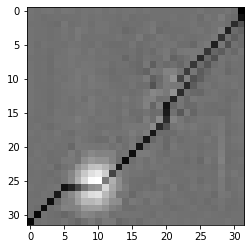

In [35]:
# Prediction on maze test values
pred_mazes = model.predict(X_test_mazes)
print("Predict image")
print(pred_mazes[0])
plt.imshow(pred_mazes[0], cmap='gray', interpolation='nearest')


In [36]:
# Save prediction images
output_dir = os.path.join(root_dir,"output")
mazes_output_dir = os.path.join(output_dir,"mazes")
for i,p in enumerate(pred_mazes):
    img_name = x_labels_test_mazes[i]
    # print(img_name)
    io.imsave(os.path.join(mazes_output_dir,img_name+".png"), p)


Lossy conversion from float32 to uint8. Range [-0.07913970947265625, 2.084592819213867]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.06799507141113281, 1.0692157745361328]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.015340805053710938, 2.6016273498535156]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.055797576904296875, 2.760477066040039]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.09295082092285156, 1.0636730194091797]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.14316368103027344, 1.0779743194580078]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.07291984558105469, 1

961


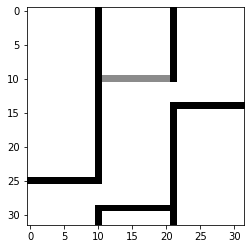

In [37]:
print(y_labels_test_mazes[0])
plt.imshow(X_test_mazes[0], cmap='gray', interpolation='nearest')

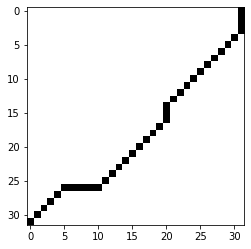

In [38]:
plt.imshow(y_test_mazes[0], cmap='gray', interpolation='nearest')

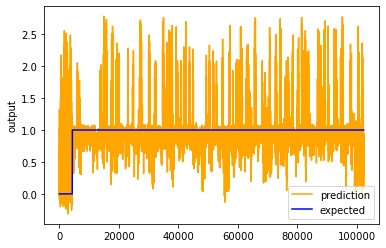

In [39]:
chart_regression(pred_mazes,y_test_mazes)

## Alternaing Gaps Model

In [40]:
# Train Model for Alternating Gaps
start_time = time.time()

model.fit(X_train_alternating_gaps, y_train_alternating_gaps,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(X_valid_alternating_gaps, y_valid_alternating_gaps))
score = model.evaluate(X_test_alternating_gaps, y_test_alternating_gaps, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

model.save("path-planning-alternating_gaps.h5")

Train on 800 samples, validate on 100 samples
Epoch 1/100
 - 1s - loss: 0.2815 - acc: 0.7271 - val_loss: 11.9316 - val_acc: 0.5183
Epoch 2/100
 - 1s - loss: 0.2476 - acc: 0.7935 - val_loss: 30.4998 - val_acc: 0.2623
Epoch 3/100
 - 2s - loss: 0.2337 - acc: 0.8161 - val_loss: 24.9517 - val_acc: 0.1643
Epoch 4/100
 - 2s - loss: 0.2238 - acc: 0.8431 - val_loss: 18.4901 - val_acc: 0.1854
Epoch 5/100
 - 2s - loss: 0.2150 - acc: 0.8606 - val_loss: 23.3944 - val_acc: 0.1709
Epoch 6/100
 - 2s - loss: 0.2050 - acc: 0.8700 - val_loss: 26.5626 - val_acc: 0.2780
Epoch 7/100
 - 1s - loss: 0.1996 - acc: 0.8781 - val_loss: 12.7118 - val_acc: 0.4627
Epoch 8/100
 - 2s - loss: 0.1951 - acc: 0.8830 - val_loss: 2.0148 - val_acc: 0.5606
Epoch 9/100
 - 1s - loss: 0.1944 - acc: 0.8764 - val_loss: 3.7372 - val_acc: 0.5743
Epoch 10/100
 - 2s - loss: 0.1898 - acc: 0.8838 - val_loss: 3.0124 - val_acc: 0.6280
Epoch 11/100
 - 1s - loss: 0.1927 - acc: 0.8732 - val_loss: 0.2860 - val_acc: 0.8292
Epoch 12/100
 - 2s - 

Predict image
[[[1.1079865 ]
  [1.1507492 ]
  [1.1508389 ]
  ...
  [0.29304695]
  [0.28912735]
  [0.27279663]]

 [[1.1486168 ]
  [1.1409836 ]
  [1.1515331 ]
  ...
  [1.1372871 ]
  [1.1492081 ]
  [1.1118679 ]]

 [[1.1498013 ]
  [1.1490078 ]
  [1.1865158 ]
  ...
  [1.1414185 ]
  [1.1523628 ]
  [1.0902462 ]]

 ...

 [[1.1563282 ]
  [1.1311493 ]
  [0.32288933]
  ...
  [1.1863213 ]
  [1.1318264 ]
  [1.1443825 ]]

 [[1.1450787 ]
  [0.30976677]
  [1.1596909 ]
  ...
  [1.1502037 ]
  [1.1246796 ]
  [1.1216049 ]]

 [[0.23139763]
  [1.1344662 ]
  [1.1533108 ]
  ...
  [1.1375103 ]
  [1.1236439 ]
  [1.0965614 ]]]


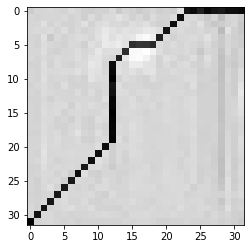

In [41]:
# Prediction on maze test values
pred_alternating_gaps = model.predict(X_test_alternating_gaps)
print("Predict image")
print(pred_alternating_gaps[0])
plt.imshow(pred_alternating_gaps[0], cmap='gray', interpolation='nearest')


In [43]:
# Save prediction images
output_dir = os.path.join(root_dir,"output")
alternating_gaps_output_dir = os.path.join(output_dir,"alternating_gaps")
for i,p in enumerate(pred_alternating_gaps):
    img_name = x_labels_test_alternating_gaps[i]
    # print(img_name)
    io.imsave(os.path.join(alternating_gaps_output_dir,img_name+".png"), p)


Lossy conversion from float32 to uint8. Range [0.2313976287841797, 1.3272743225097656]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.19575119018554688, 1.3477325439453125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.2002277374267578, 1.3507022857666016]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.19575119018554688, 1.3477325439453125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.2002277374267578, 1.3507022857666016]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.19575119018554688, 1.3477325439453125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.2320690155029297, 1.3390560150

961


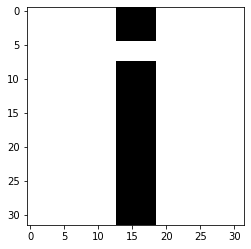

In [44]:
print(y_labels_test_alternating_gaps[0])
plt.imshow(X_test_alternating_gaps[0], cmap='gray', interpolation='nearest')

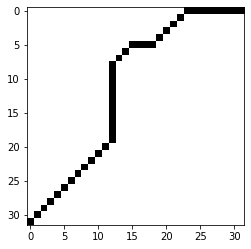

In [45]:
plt.imshow(y_test_alternating_gaps[0], cmap='gray', interpolation='nearest')

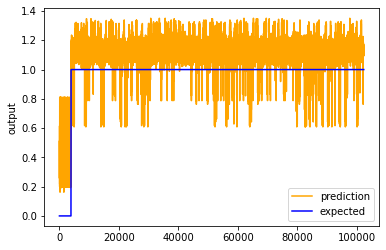

In [46]:
chart_regression(pred_alternating_gaps,y_test_alternating_gaps)

## Bugtrap Forest Model

In [47]:
# Train Model for Bugtrap Forest
start_time = time.time()

model.fit(X_train_bugtrap_forest, y_train_bugtrap_forest,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(X_valid_bugtrap_forest, y_valid_bugtrap_forest))
score = model.evaluate(X_test_bugtrap_forest, y_test_bugtrap_forest, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

model.save("path-planning-bugtrap_forest.h5")

Train on 800 samples, validate on 100 samples
Epoch 1/100
 - 1s - loss: 0.1457 - acc: 0.8593 - val_loss: 0.2528 - val_acc: 0.7943
Epoch 2/100
 - 1s - loss: 0.1302 - acc: 0.8729 - val_loss: 0.8933 - val_acc: 0.6416
Epoch 3/100
 - 1s - loss: 0.1276 - acc: 0.8733 - val_loss: 0.3528 - val_acc: 0.7000
Epoch 4/100
 - 2s - loss: 0.1220 - acc: 0.8784 - val_loss: 0.4298 - val_acc: 0.7319
Epoch 5/100
 - 2s - loss: 0.1214 - acc: 0.8789 - val_loss: 0.4504 - val_acc: 0.7312
Epoch 6/100
 - 2s - loss: 0.1194 - acc: 0.8804 - val_loss: 0.1904 - val_acc: 0.8218
Epoch 7/100
 - 2s - loss: 0.1174 - acc: 0.8823 - val_loss: 0.1537 - val_acc: 0.8645
Epoch 8/100
 - 2s - loss: 0.1177 - acc: 0.8816 - val_loss: 0.1244 - val_acc: 0.9055
Epoch 9/100
 - 2s - loss: 0.1159 - acc: 0.8835 - val_loss: 0.1123 - val_acc: 0.9088
Epoch 10/100
 - 2s - loss: 0.1169 - acc: 0.8838 - val_loss: 0.1076 - val_acc: 0.9097
Epoch 11/100
 - 2s - loss: 0.1151 - acc: 0.8845 - val_loss: 0.0881 - val_acc: 0.9216
Epoch 12/100
 - 2s - loss: 0

Predict image
[[[1.0956097 ]
  [1.0938606 ]
  [1.079937  ]
  ...
  [0.36203575]
  [0.35778618]
  [0.3401966 ]]

 [[1.0978775 ]
  [1.0926762 ]
  [1.0815868 ]
  ...
  [1.0579777 ]
  [1.0315495 ]
  [1.0807629 ]]

 [[1.1197491 ]
  [1.1083412 ]
  [1.0871716 ]
  ...
  [1.1024246 ]
  [1.056467  ]
  [1.0932293 ]]

 ...

 [[1.113163  ]
  [1.1008644 ]
  [0.25875854]
  ...
  [1.0786362 ]
  [1.0914993 ]
  [1.0848637 ]]

 [[1.0931892 ]
  [0.2210846 ]
  [1.1000347 ]
  ...
  [1.1139908 ]
  [1.1024246 ]
  [1.0759907 ]]

 [[0.18614006]
  [1.0981236 ]
  [1.0880337 ]
  ...
  [1.1081734 ]
  [1.108305  ]
  [1.0670414 ]]]


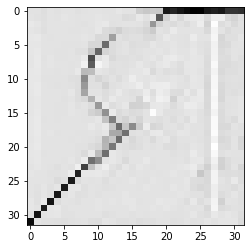

In [48]:
# Prediction on maze test values
pred_bugtrap_forest = model.predict(X_test_bugtrap_forest)
print("Predict image")
print(pred_bugtrap_forest[0])
plt.imshow(pred_bugtrap_forest[0], cmap='gray', interpolation='nearest')


In [49]:
# Save prediction images
output_dir = os.path.join(root_dir,"output")
bugtrap_forest_output_dir = os.path.join(output_dir,"bugtrap_forest")
for i,p in enumerate(pred_bugtrap_forest):
    img_name = x_labels_test_bugtrap_forest[i]
    # print(img_name)
    io.imsave(os.path.join(bugtrap_forest_output_dir,img_name+".png"), p)


Lossy conversion from float32 to uint8. Range [0.13568687438964844, 1.2203807830810547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.13361740112304688, 1.3358821868896484]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.12361335754394531, 1.2324905395507812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.161376953125, 1.2324676513671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.13487815856933594, 1.3821487426757812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.09391021728515625, 1.2350845336914062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.13529205322265625, 1.232461929

961


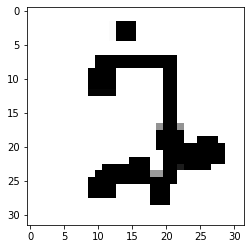

In [50]:
print(y_labels_test_bugtrap_forest[0])
plt.imshow(X_test_bugtrap_forest[0], cmap='gray', interpolation='nearest')

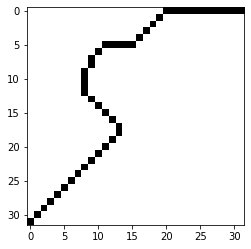

In [51]:
plt.imshow(y_test_bugtrap_forest[0], cmap='gray', interpolation='nearest')

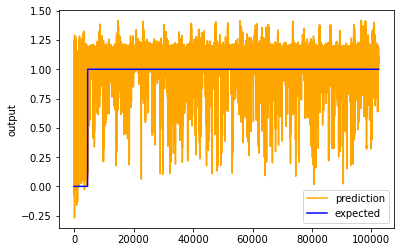

In [52]:
chart_regression(pred_bugtrap_forest,y_test_bugtrap_forest)

## Multiple Bugtraps Model

In [53]:
# Train Model for Mazes
start_time = time.time()

model.fit(X_train_multiple_bugtraps, y_train_multiple_bugtraps,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(X_valid_multiple_bugtraps, y_valid_multiple_bugtraps))
score = model.evaluate(X_test_multiple_bugtraps, y_test_multiple_bugtraps, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

model.save("path-planning-multiple_bugtraps.h5")

Train on 800 samples, validate on 100 samples
Epoch 1/100
 - 1s - loss: 0.1245 - acc: 0.8747 - val_loss: 0.0482 - val_acc: 0.9739
Epoch 2/100
 - 1s - loss: 0.1136 - acc: 0.8853 - val_loss: 0.0613 - val_acc: 0.9581
Epoch 3/100
 - 1s - loss: 0.1112 - acc: 0.8878 - val_loss: 0.0737 - val_acc: 0.9568
Epoch 4/100
 - 1s - loss: 0.1115 - acc: 0.8880 - val_loss: 0.0620 - val_acc: 0.9762
Epoch 5/100
 - 1s - loss: 0.1107 - acc: 0.8886 - val_loss: 0.0823 - val_acc: 0.9776
Epoch 6/100
 - 1s - loss: 0.1089 - acc: 0.8905 - val_loss: 0.1016 - val_acc: 0.9755
Epoch 7/100
 - 1s - loss: 0.1076 - acc: 0.8918 - val_loss: 0.1103 - val_acc: 0.9812
Epoch 8/100
 - 1s - loss: 0.1051 - acc: 0.8945 - val_loss: 0.1124 - val_acc: 0.9801
Epoch 9/100
 - 1s - loss: 0.1048 - acc: 0.8950 - val_loss: 0.1122 - val_acc: 0.9810
Epoch 10/100
 - 1s - loss: 0.1038 - acc: 0.8956 - val_loss: 0.1016 - val_acc: 0.9804
Epoch 11/100
 - 1s - loss: 0.1032 - acc: 0.8963 - val_loss: 0.0878 - val_acc: 0.9821
Epoch 12/100
 - 1s - loss: 0

Predict image
[[[1.0253944 ]
  [1.029726  ]
  [1.0189228 ]
  ...
  [0.27404594]
  [0.24402237]
  [0.18631935]]

 [[1.0275707 ]
  [1.028532  ]
  [1.0333004 ]
  ...
  [1.0623074 ]
  [1.0381336 ]
  [0.9282112 ]]

 [[1.0330353 ]
  [1.0416126 ]
  [1.0347424 ]
  ...
  [1.0639591 ]
  [1.0151901 ]
  [0.88269806]]

 ...

 [[1.0259266 ]
  [1.0182114 ]
  [0.1642704 ]
  ...
  [1.0341339 ]
  [1.0381279 ]
  [1.0203857 ]]

 [[1.0297451 ]
  [0.15659904]
  [1.0394058 ]
  ...
  [1.0235443 ]
  [1.0336571 ]
  [1.0182972 ]]

 [[0.11491585]
  [1.0314922 ]
  [1.0337543 ]
  ...
  [1.0199795 ]
  [1.0279751 ]
  [1.0222702 ]]]


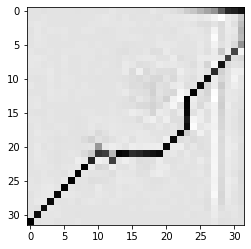

In [54]:
# Prediction on maze test values
pred_multiple_bugtraps = model.predict(X_test_multiple_bugtraps)
print("Predict image")
print(pred_multiple_bugtraps[0])
plt.imshow(pred_multiple_bugtraps[0], cmap='gray', interpolation='nearest')


In [55]:
# Save prediction images
output_dir = os.path.join(root_dir,"output")
multiple_bugtraps_output_dir = os.path.join(output_dir,"multiple_bugtraps")
for i,p in enumerate(pred_multiple_bugtraps):
    img_name = x_labels_test_multiple_bugtraps[i]
    # print(img_name)
    io.imsave(os.path.join(multiple_bugtraps_output_dir,img_name+".png"), p)


Lossy conversion from float32 to uint8. Range [0.10701179504394531, 1.1420440673828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.031169891357421875, 1.1243953704833984]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0664825439453125, 1.1362361907958984]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.01641845703125, 1.1290855407714844]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.04179573059082031, 1.1331672668457031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.11653327941894531, 1.1077251434326172]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.06644439697265625, 1.156448364

961


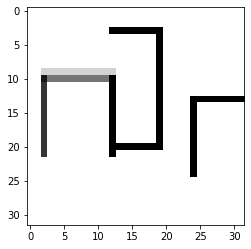

In [56]:
print(y_labels_test_multiple_bugtraps[0])
plt.imshow(X_test_multiple_bugtraps[0], cmap='gray', interpolation='nearest')

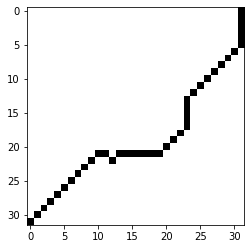

In [57]:
plt.imshow(y_test_multiple_bugtraps[0], cmap='gray', interpolation='nearest')

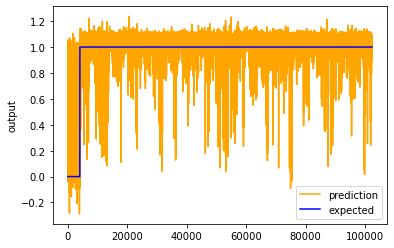

In [58]:
chart_regression(pred_multiple_bugtraps,y_test_multiple_bugtraps)

## Shifting Gaps Model

In [59]:
# Train Model for Mazes
start_time = time.time()

model.fit(X_train_shifting_gaps, y_train_shifting_gaps,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(X_valid_shifting_gaps, y_valid_shifting_gaps))
score = model.evaluate(X_test_shifting_gaps, y_test_shifting_gaps, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

model.save("path-planning-shifting_gaps.h5")

Train on 800 samples, validate on 100 samples
Epoch 1/100
 - 1s - loss: 0.1273 - acc: 0.8708 - val_loss: 2.0307 - val_acc: 0.6134
Epoch 2/100
 - 1s - loss: 0.1186 - acc: 0.8801 - val_loss: 12.1415 - val_acc: 0.4077
Epoch 3/100
 - 1s - loss: 0.1137 - acc: 0.8866 - val_loss: 85.3940 - val_acc: 0.2828
Epoch 4/100
 - 1s - loss: 0.1087 - acc: 0.8924 - val_loss: 20.3166 - val_acc: 0.2241
Epoch 5/100
 - 1s - loss: 0.1044 - acc: 0.8959 - val_loss: 6.7054 - val_acc: 0.2940
Epoch 6/100
 - 1s - loss: 0.1027 - acc: 0.8974 - val_loss: 11.2030 - val_acc: 0.3468
Epoch 7/100
 - 1s - loss: 0.1007 - acc: 0.8992 - val_loss: 3.9537 - val_acc: 0.3654
Epoch 8/100
 - 1s - loss: 0.1000 - acc: 0.9001 - val_loss: 3.0314 - val_acc: 0.4113
Epoch 9/100
 - 1s - loss: 0.0995 - acc: 0.9008 - val_loss: 1.7352 - val_acc: 0.4793
Epoch 10/100
 - 1s - loss: 0.1003 - acc: 0.8996 - val_loss: 1.0350 - val_acc: 0.5649
Epoch 11/100
 - 1s - loss: 0.0993 - acc: 0.9008 - val_loss: 0.6915 - val_acc: 0.6545
Epoch 12/100
 - 1s - los

Predict image
[[[1.0018158 ]
  [1.0017776 ]
  [0.9999695 ]
  ...
  [0.11178017]
  [0.12273216]
  [0.10112572]]

 [[1.0047398 ]
  [1.0155735 ]
  [0.9944782 ]
  ...
  [1.0178318 ]
  [0.98604393]
  [0.99126816]]

 [[1.0058327 ]
  [1.0110722 ]
  [1.0027885 ]
  ...
  [1.0181046 ]
  [0.98428535]
  [0.98264503]]

 ...

 [[0.9881706 ]
  [1.0113506 ]
  [0.09724236]
  ...
  [0.9973049 ]
  [0.98929405]
  [0.98483276]]

 [[0.99809074]
  [0.08432579]
  [1.0091515 ]
  ...
  [0.98931503]
  [0.99995995]
  [0.9957142 ]]

 [[0.10453224]
  [0.9950981 ]
  [1.0018368 ]
  ...
  [1.0031776 ]
  [0.97971725]
  [0.9844322 ]]]


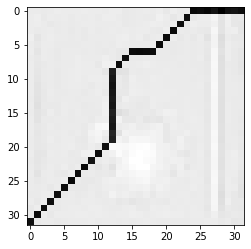

In [60]:
# Prediction on maze test values
pred_shifting_gaps = model.predict(X_test_shifting_gaps)
print("Predict image")
print(pred_shifting_gaps[0])
plt.imshow(pred_shifting_gaps[0], cmap='gray', interpolation='nearest')


In [61]:
# Save prediction images
output_dir = os.path.join(root_dir,"output")
shifting_gaps_output_dir = os.path.join(output_dir,"shifting_gaps")
for i,p in enumerate(pred_shifting_gaps):
    img_name = x_labels_test_shifting_gaps[i]
    # print(img_name)
    io.imsave(os.path.join(shifting_gaps_output_dir,img_name+".png"), p)


Lossy conversion from float32 to uint8. Range [0.0400238037109375, 1.0859127044677734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.06653213500976562, 1.099710464477539]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.029750823974609375, 1.0697917938232422]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.058612823486328125, 1.1049022674560547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.059207916259765625, 1.0930519104003906]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0070781707763671875, 1.0661811828613281]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.04540252685546875, 1.083

961


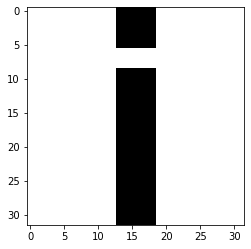

In [62]:
print(y_labels_test_shifting_gaps[0])
plt.imshow(X_test_shifting_gaps[0], cmap='gray', interpolation='nearest')

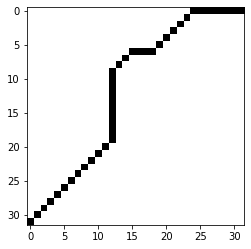

In [63]:
plt.imshow(y_test_shifting_gaps[0], cmap='gray', interpolation='nearest')

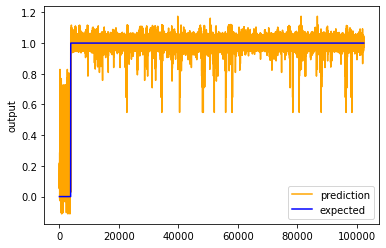

In [64]:
chart_regression(pred_shifting_gaps,y_test_shifting_gaps)

## Forest Model

In [65]:
# Train Model for Mazes
start_time = time.time()

model.fit(X_train_forest, y_train_forest,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(X_valid_forest, y_valid_forest))
score = model.evaluate(X_test_forest, y_test_forest, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

model.save("path-planning-forest.h5")

Train on 800 samples, validate on 100 samples
Epoch 1/100
 - 1s - loss: 0.1308 - acc: 0.8674 - val_loss: 0.1893 - val_acc: 0.9220
Epoch 2/100
 - 1s - loss: 0.1266 - acc: 0.8717 - val_loss: 7.3559 - val_acc: 0.7773
Epoch 3/100
 - 1s - loss: 0.1240 - acc: 0.8730 - val_loss: 4.3421 - val_acc: 0.7835
Epoch 4/100
 - 1s - loss: 0.1225 - acc: 0.8733 - val_loss: 0.2390 - val_acc: 0.8765
Epoch 5/100
 - 1s - loss: 0.1194 - acc: 0.8759 - val_loss: 1.4071 - val_acc: 0.8434
Epoch 6/100
 - 1s - loss: 0.1186 - acc: 0.8764 - val_loss: 0.1272 - val_acc: 0.9300
Epoch 7/100
 - 1s - loss: 0.1179 - acc: 0.8769 - val_loss: 0.2962 - val_acc: 0.9223
Epoch 8/100
 - 1s - loss: 0.1189 - acc: 0.8757 - val_loss: 0.2482 - val_acc: 0.8958
Epoch 9/100
 - 1s - loss: 0.1525 - acc: 0.8637 - val_loss: 0.5222 - val_acc: 0.0593
Epoch 10/100
 - 1s - loss: 0.2603 - acc: 0.8402 - val_loss: 13.4600 - val_acc: 0.0151
Epoch 11/100
 - 1s - loss: 0.2000 - acc: 0.8437 - val_loss: 478.0311 - val_acc: 9.7656e-06
Epoch 12/100
 - 1s - 

Predict image
[[[0.8508396 ]
  [0.90810776]
  [0.91093636]
  ...
  [0.09015846]
  [0.04117203]
  [0.02451134]]

 [[0.8825016 ]
  [0.9189186 ]
  [0.9436016 ]
  ...
  [0.9202347 ]
  [0.9043884 ]
  [0.7983055 ]]

 [[0.90639687]
  [0.9298744 ]
  [0.94937706]
  ...
  [0.99891853]
  [0.9336815 ]
  [0.9003563 ]]

 ...

 [[0.8945255 ]
  [0.90563774]
  [0.34692   ]
  ...
  [0.8692856 ]
  [0.9156227 ]
  [0.86125565]]

 [[0.86382675]
  [0.4161911 ]
  [0.94540024]
  ...
  [0.91391754]
  [0.944191  ]
  [0.8781147 ]]

 [[0.11000824]
  [0.8969593 ]
  [0.91277695]
  ...
  [0.90782356]
  [0.922493  ]
  [0.8722248 ]]]


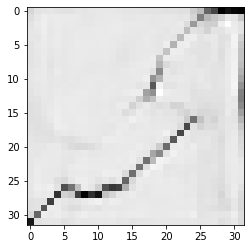

In [66]:
# Prediction on maze test values
pred_forest = model.predict(X_test_forest)
print("Predict image")
print(pred_forest[0])
plt.imshow(pred_forest[0], cmap='gray', interpolation='nearest')


In [67]:
# Save prediction images
output_dir = os.path.join(root_dir,"output")
forest_output_dir = os.path.join(output_dir,"forest")
for i,p in enumerate(pred_forest):
    img_name = x_labels_test_forest[i]
    # print(img_name)
    io.imsave(os.path.join(forest_output_dir,img_name+".png"), p)


Lossy conversion from float32 to uint8. Range [0.019533157348632812, 1.0137748718261719]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.0006103515625, 0.9798946380615234]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.0028171539306640625, 0.9684371948242188]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.0293426513671875, 0.9986248016357422]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.06922340393066406, 1.0110301971435547]. Convert image to uint8 prior to saving to suppress this 

961


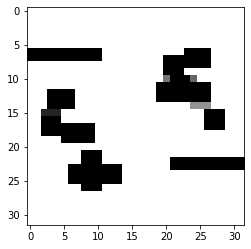

In [68]:
print(y_labels_test_forest[0])
plt.imshow(X_test_forest[0], cmap='gray', interpolation='nearest')

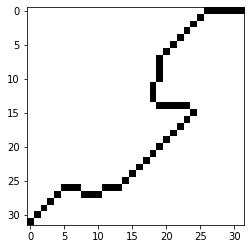

In [69]:
plt.imshow(y_test_forest[0], cmap='gray', interpolation='nearest')

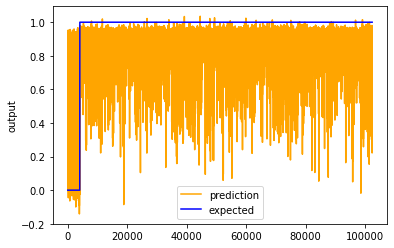

In [70]:
chart_regression(pred_forest,y_test_forest)

## Combined Paths Model